In [1]:
# import packages
%pylab inline

import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.util import add_cyclic_point
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import colorbar, colors
from scipy.stats import poisson
import numpy as np
import random
import regionmask
from scipy.stats import linregress

import sys
wython = '/tigress/wenchang/wython'
if wython not in sys.path: sys.path.append(wython)
from xtc import wherebasin

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

In [3]:

from matplotlib import path

def tc_basins(latN=90, latS=-90):
    '''use regionmask to create 8 TC basins'''
    #latN = 90 # north boundary lat
    #latS = -90 # south bounday lat
    name = 'TCBasins'
    names = ['North Atlantic', 'East Pacific', 'West Pacific', 'North Indian',
            'South Indian', 'Australia', 'South Pacific', 'South Atlantic']
    abbrevs = ['NA', 'EP', 'WP', 'NI',
              'SI', 'AU', 'SP', 'SA']
    outlines = [( (295, 0), (260, 20), (260, latN), (360, latN), (360, 0) ),
                ( (200, 0), (200, latN), (260, latN), (260, 20), (295, 0) ),
                ( (105, 0), (105, latN), (200, latN), (200, 0) ),
                ( (30, 0), (30, latN), (105, latN), (105, 0) ),
                ( (30, 0), (30, latS), (105, latS), (105, 0) ),
                ( (105,0), (105, latS), (165, latS), (165, 0) ),
                ( (165, 0), (165, latS), (290, latS), (290, 0) ),
                ( (290, 0), (290, latS), (360, latS), (360, 0) ),
               ]
    numbers = np.arange(len(names))
    # Regions_cls was replaced by Regions since version 0.5.0 of regionmask
    if hasattr(regionmask, 'Regions'):
        Regions = regionmask.Regions
    else:
        Regions = regionmask.Regions_cls
        print('**old versions of regionmask is used: regionmask.Regions_cls**')
    #bs = regionmask.Regions_cls(name=name,
    #bs = regionmask.Regions(name=name,
    bs =             Regions(name=name,
                                numbers=numbers,
                                names=names,
                                abbrevs=abbrevs,
                                outlines=outlines)
    return bs

def tracks_in_basin(ds, basin):
    '''Get the basin bool mask for the tracks dataset.
    **input**:
        ds: tracks dataset;
        basin: basin tag, e.g. "NA" for North Atlantic. 
    **return**:
        in_basin: DataArray of basin mask (bool values)'''
#     ds = xtc.tc_tracks('CTL1860_noleap_tigercpu_intelmpi_18_576PE', years=range(1,11))
#     basin = 'NA'
    # create basin_domain given basin tag, e.g. 'NA' (North Atlantic)
    basins = tc_basins()
    basin_index = basins.map_keys(basin)
    basin_domain = path.Path(basins.coords[basin_index])
    
    # create DataArray of lon/lat pairs
    lon = ds.lon.stack(i_stack=ds.lon.dims)
    lat = ds.lat.stack(i_stack=ds.lat.dims)
    lonlat = xr.concat([lon, lat], dim='lonlat').transpose()
    in_basin = lon.copy().astype('bool') # DataArray to hold the result
    
    # get the basin bool mask for all the tracks
    in_basin.data = basin_domain.contains_points(lonlat)
    in_basin = in_basin.unstack() # unstack to recover the original shape
    
    return in_basin

def wherebasin(da, basin):
    '''mask the input DataArray da by a given basin (e.g. 'NA'). da has lon/lat coordinates'''
    bs = tc_basins()
    return da.where( bs.mask(da) == bs.map_keys(basin) )



In [4]:
import xarray as xr, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.collections import LineCollection
from geoplots import mapplot

def single_track_plot(lonvec, latvec, vmvec, ax=None, lw=1, alpha=1):
    '''plot TC a TC track with varied colors indicating wind spead.'''
    if ax is None:
        ax = plt.gca()
    
    # create segments for the LineCollection
    L = ~np.isnan(lonvec)
    x = lonvec[L]
    y = latvec[L]
    vm = vmvec[L]
    vm = (vm[:-1] + vm[1:])/2.0
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # colormap from: 
    # https://upload.wikimedia.org/wikipedia/commons/6/6f/Tropical_cyclones_1945_2006_wikicolor.png
    c = ListedColormap(np.array([(114, 185, 249),
                                (122, 246, 244),
                                (255, 254, 209),
                                (252, 231, 134),
                                (247, 195, 90),
                                (241, 148, 64),
                                (238, 107, 103)])/255.0 )
    levels = [0, 18, 33, 43, 50, 58 , 70, 100]
    norm = BoundaryNorm(levels, c.N)
    
    # LineCollection objects
    lc = LineCollection(segments, cmap=c, norm=norm)
    lc.set_array(vm)
    lc.set_linewidth(lw)
    lc.set_alpha(alpha)

    lines = ax.add_collection(lc)
    ax.autoscale()
    
    return lines

def trackplot(ds, **kwargs):
    '''plot TC a TC track with varied colors indicating wind spead.
    kwargs include: 
        ax(=plt.gca()), 
        lw(=0.5), 
        alpha(=0.5). 
        
    **usage**
        lines = trackplot(ds.isel(year=slice(0,10)), alpha=1)
        plt.colorbar(lines.isel(year=0, storm=0).item())
    '''    
    lines = xr.apply_ufunc(single_track_plot,
                          ds.lon, ds.lat, ds.windmax,
                          input_core_dims=[['stage'], ['stage'], ['stage']],
                          vectorize=True,
                          kwargs=kwargs)
    ax = kwargs.pop('ax', plt.gca())
    ax.autoscale()
    
    return lines

There are some problems for the deprecated basemap package.


In [7]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/model_test/stitch_data_output'

# ----- ERA5 data ---------

ds = xr.open_dataset("{}/HIRAM_test_en01_2019.nc".format(dloc)).load()

hiram_atl = ds.where(tracks_in_basin(ds, 'NA'), drop=True)



/tmp/ipykernel_4003697/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


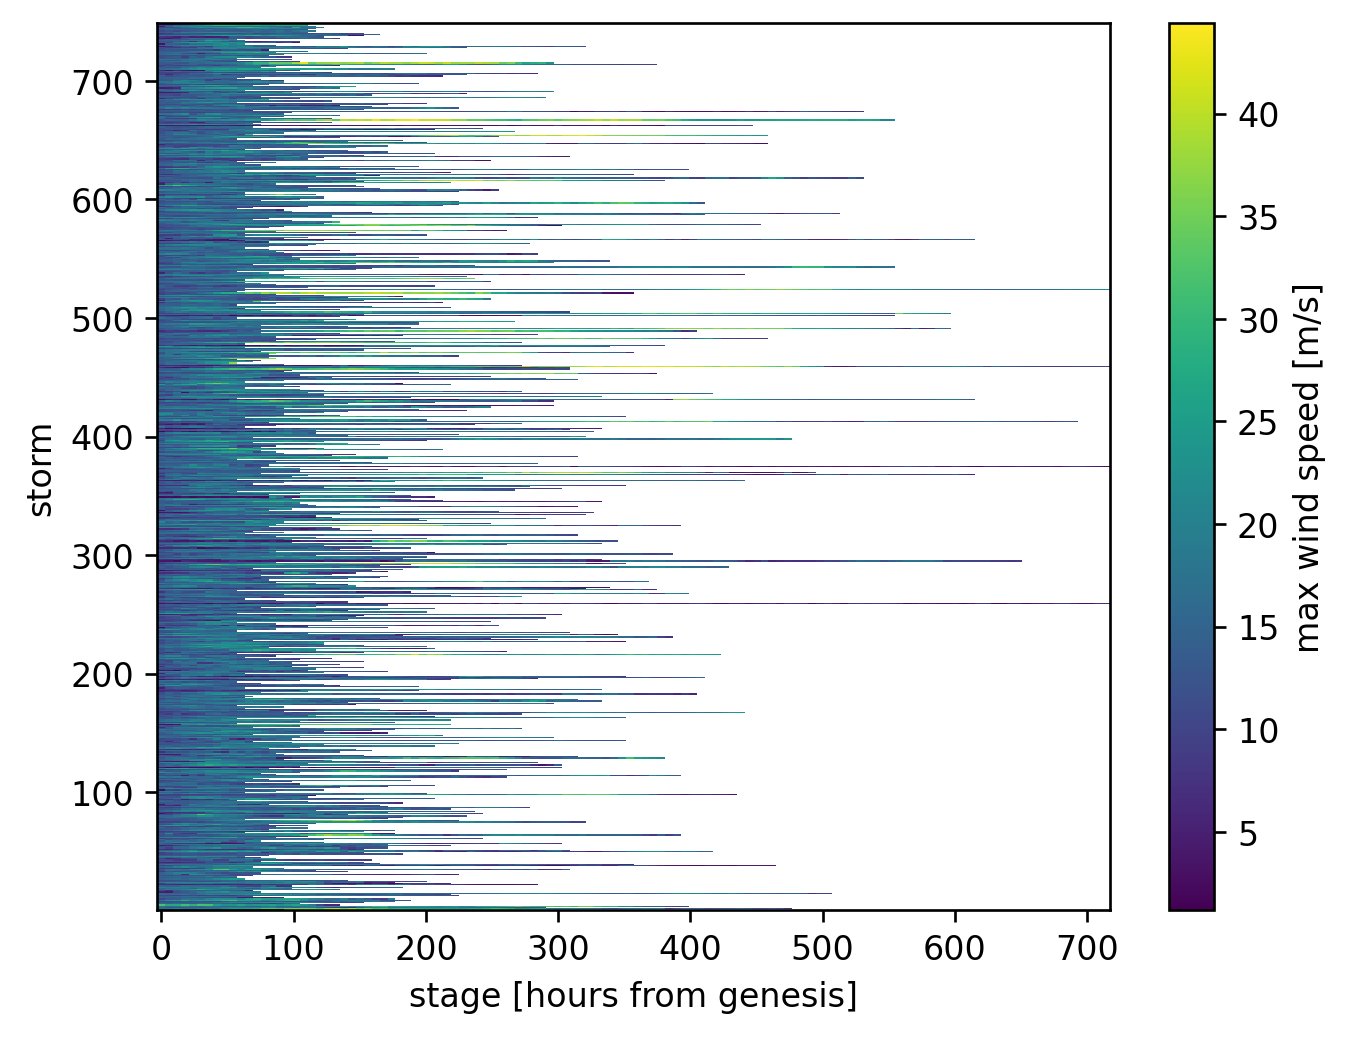

In [9]:
ds.windmax.plot()

In [18]:
hiram_atl['lon'] = (((hiram_atl.lon + 180) % 360) - 180)

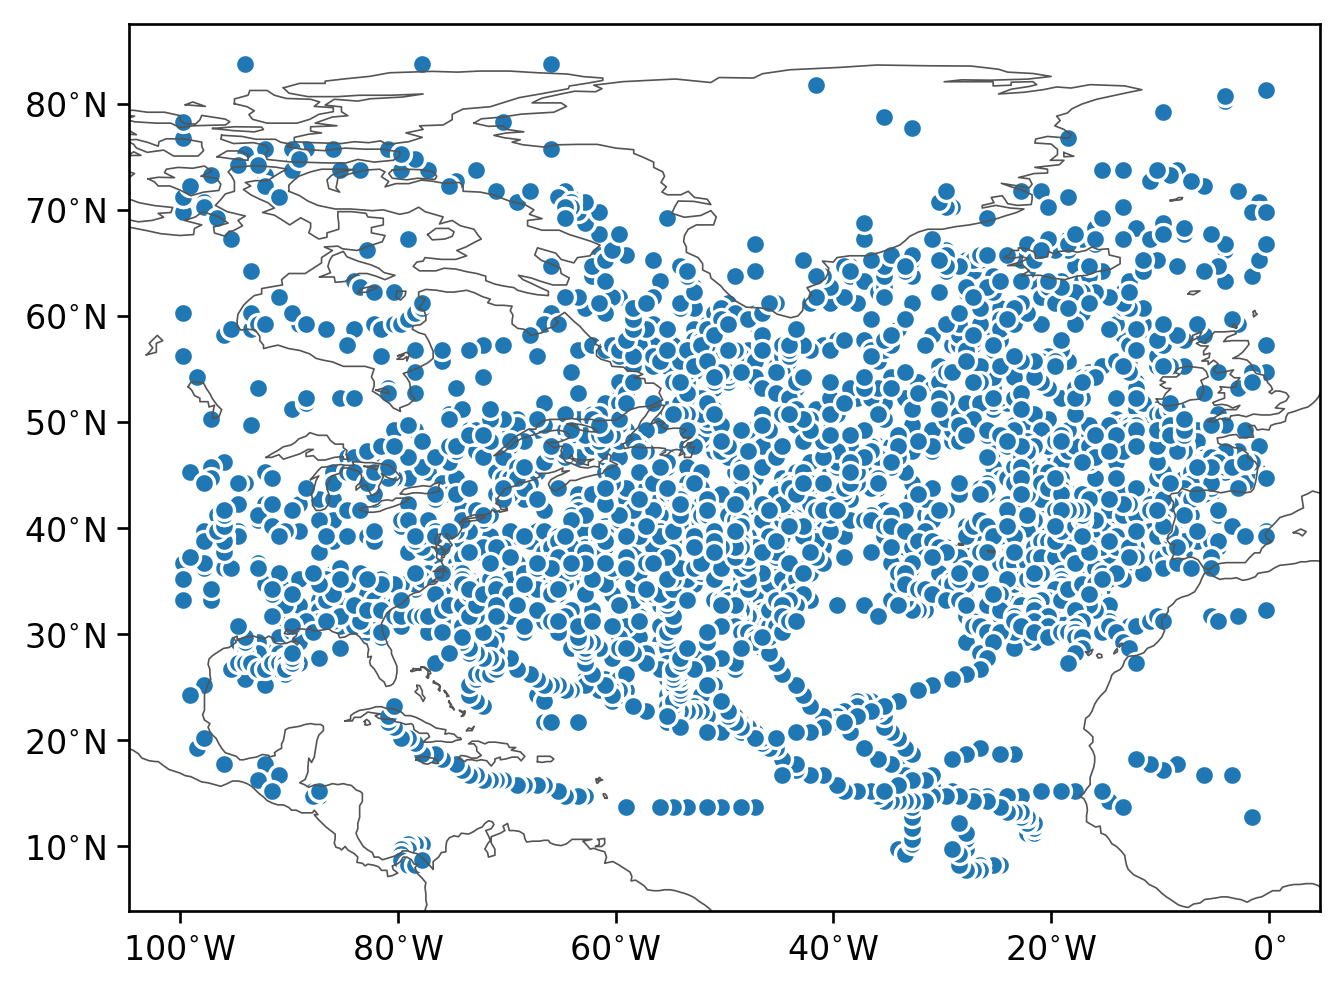

In [21]:
hiram_atl.plot.scatter(x='lon', y='lat')
mapplot()

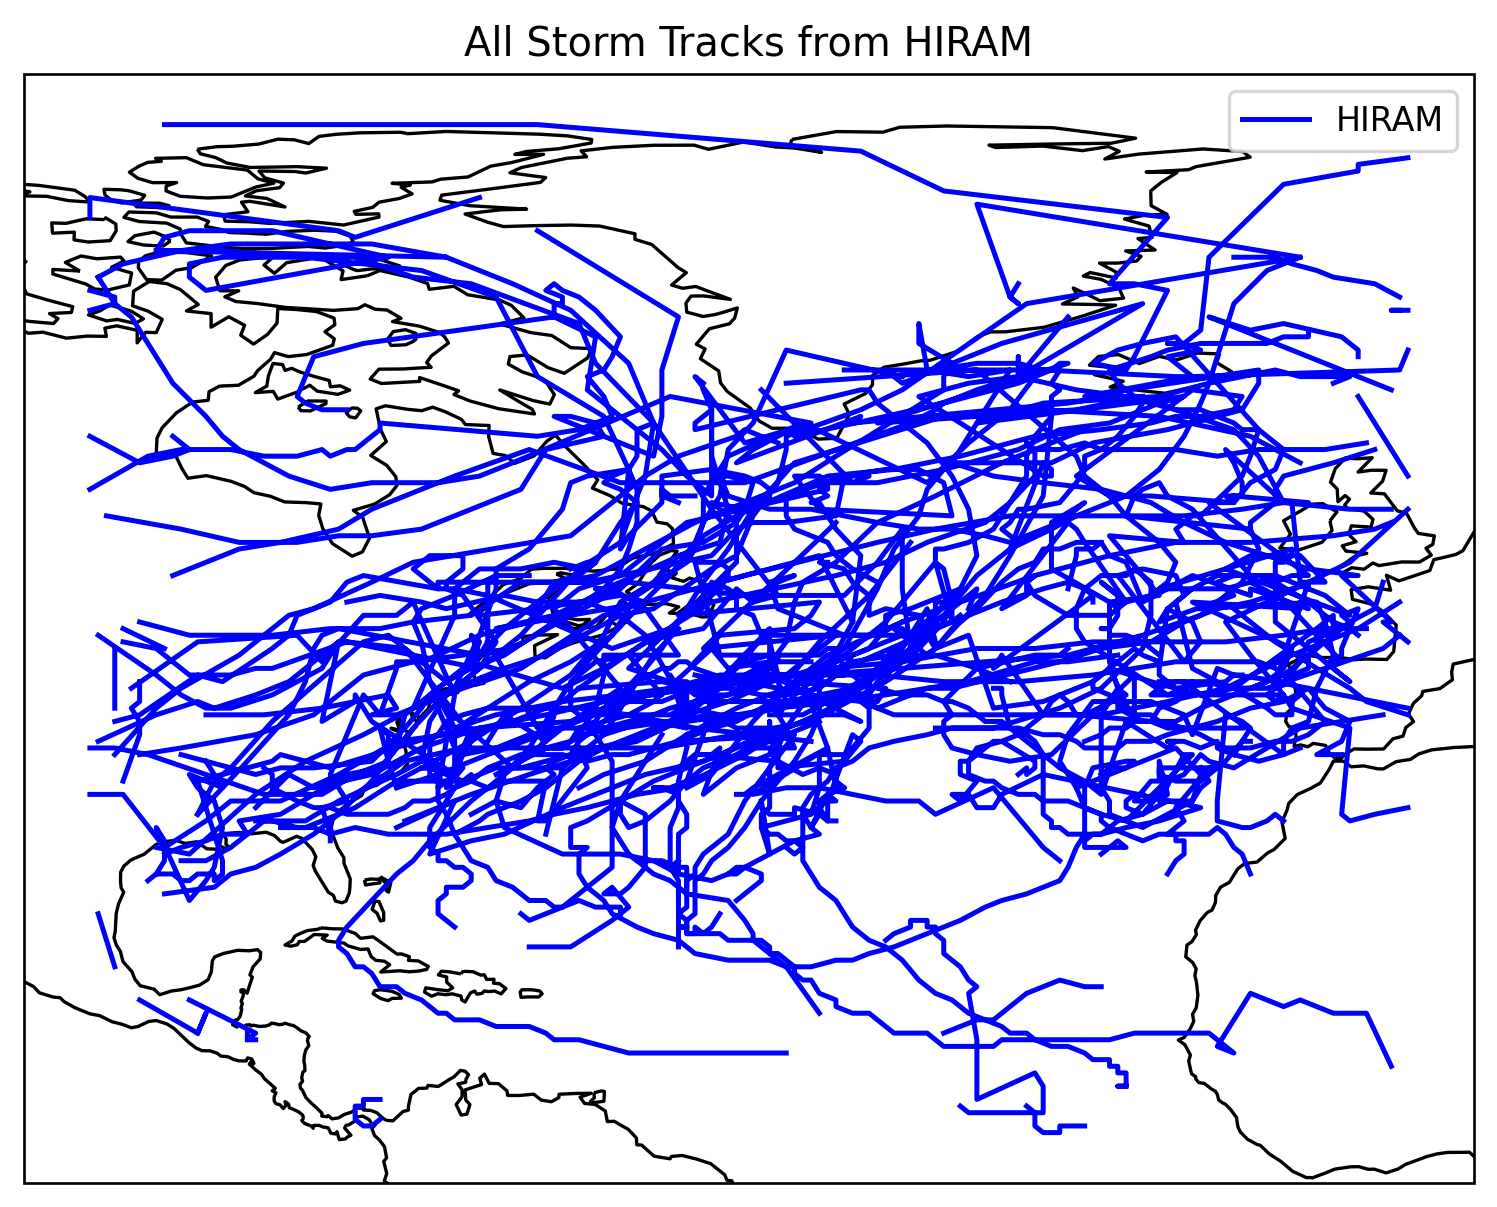

In [23]:
# Setup projection (PlateCarree works for lat/lon)
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})

# Add coastlines and optional features
ax.coastlines()

# Plot ET storm track points
ax.plot(hiram_atl.lon.values.flat,
        hiram_atl.lat.values.flat,
        color='b',
        linestyle='-',
        label='HIRAM')

# Add legend and title
ax.legend()
ax.set_title("All Storm Tracks from HIRAM")

# Optional: Set lat/lon extent
# ax.set_extent([-100, 20, 0, 60])  # Example for Atlantic

plt.show()